In [1]:
## import for plotting inline
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
## import for scipy
import pandas as pd
import numpy as np
from scipy import signal

Load the data in the notebook, you should specify the variable **path_to_data** to the folder where you extracted the archive.

In [3]:
path_to_data = './'
touch_t = pd.read_json(path_to_data+'touch_t_json.df')
metasession = pd.read_json(path_to_data+'meta_json.df')

There is 2 pandas dataframes, **touch_t** which contains the touch data in a flat structure and **metasession** that indicates which rows in **touch_t** belongs to which session.

The columns for touch_t are:
- **session**: the id of the session, equivalent to one unique repetition
- **t**: the time at which the row was recorded, can be translated with datetime.datetime.fromtimestamp(t)
- **fid**: the frame id within the session, always starting at 0

- **ntouch**: the number of detected touch as recorded by the tablet, 0 if not touching
- **x**: the x coordinate of the touch contact, as recorded by the tablet, -1 if not touching
- **y**: the y coordinate of the touch contact, as recorded by the tablet, -1 if not touching

- **touch_**: whether this is a touch frame as classified by optical system
- **x_**: the x coordinate of the touch contact as regressed by optical system
- **y_**: the y coordinate of the touch contact as regressed by optical system

About the time between frames, the sampling rate is 30FPS, with possible variations, the column **t** should be more precise but I have not been needing it in my decoding yet.

As you can see, for each rows (e.g. each recorded frame) there is the data from the tablet, which we used as ground truth, and the infered data based on the optical system.


The columns for metasession are:
- **type**: the type of the condition, can be word or sentences
- **name**: the name of the condition, litteraly the word or sentences that should be inputed
- **bound**: the list of the session ids (link to touch_t) that recorded this condition

As a results, the **metasession** df describes the content of the dataset, and each trials can be fetch with a groupby and a conditional filtering on **touch_t** on sessions id.

## helper functions for plotting and filtering

In [4]:
tablet_size = (25.4, 16.93)

from scipy import misc
keyboard = misc.imread(path_to_data+'keyboard.png')  ## requires pil

def ones_runs(a):
    absdiff = np.abs(np.diff(np.r_[0, a, 0]))
    return np.where(absdiff == 1)[0].reshape(-1, 2)

def datafilter(data, source='inferred'):
    '''Transform the columns name to be transparent to the plotting part.
    Filter the rows by keeping only the touching frames, and removing the head and tail of the 
    data when using optical source.'''
    
    if source == 'inferred':
        xyt = data[['t', 'x_', 'y_', 'touch_']]
        xyt.columns = ['t', 'x', 'y', 'touch']
    elif source == 'ground':
        xyt = data[['t', 'x', 'y', 'ntouch']]
        xyt.columns = ['t', 'x', 'y', 'touch']
    else: raise ValueError("wrong source, can be 'infered' or 'ground'")

    ## only keep the touch frames
    xyt = xyt[(xyt['touch'] != 0)]
    
    ## scale to fit the real size
    xyt = xyt * ((1,) + tablet_size + (1,))
    
    ## and remove the head and tail if infered - this circumvent a poor classification 
    if source == 'inferred': xyt = xyt[5:-5]
    
    return xyt

def touchfilter(data, source='inferred'):
    if source == 'ground': return (data['ntouch'] > 0).astype(int)
    elif source == 'inferred':
        touch_medfilt = signal.medfilt(data['touch_'].values, kernel_size=3)
        return touch_medfilt
        
    else: raise ValueError("wrong source, can be 'infered' or 'ground'")

def sugar_plot(ax):
    '''Add the keyboard in the background and the axis names.'''
    ax.set_xlim([0,25.4]);ax.set_ylim([0,16.93])
    ax.imshow(keyboard, zorder=0, extent=[0.0, 25.4, 0.0, 16.93])
    ax.set_xlabel('x [cm]');ax.set_ylabel('y [cm]');ax.set_xlim([0,25.4]);ax.set_ylim([0,16.93])

    

# print a word condition

By filtering on the metassion and the type 'word', you can see all the conditions that were recoreded, and their associated sessions:

In [5]:
mwords = metasession[metasession['type'] == 'word']
mwords.head(5)

,bound,name,type
61,"[273, 318, 363, 408]",help,word
62,"[274, 319, 364, 409]",just,word
63,"[275, 320, 365, 410]",don't,word
64,"[276, 321, 366, 411]",soon,word
65,"[277, 322, 367, 412]",go,word


So to plot a word trajectory, we will choose a condition name in the mword df and extract all the rows from 
touch_t that are related:

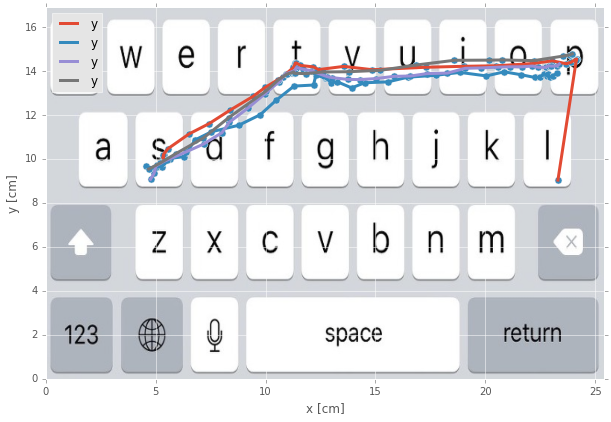

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

source = 'inferred'  # or 'ground'
word = "stop"

sessions_word = mwords[mwords['name'] == word]['bound'].iloc[0]
for session in sessions_word:
    data = touch_t[touch_t['session'] == session]
    
    txyt = datafilter(data, source=source)

    txyt.plot(x='x', y='y', linewidth=3, ax=ax)
    txyt.plot(x='x', y='y', kind='scatter', s=50, ax=ax)

sugar_plot(ax)

# print a sentence

The sentences are stored in the same fashion, however they are constitued of several words and will be split and plotted accordingly.

In [7]:
msentences = metasession[metasession['type'] == 'sentence']
msentences.head(5)

,bound,name,type
111,"[297, 342, 387, 432]",i like it very much,sentence
112,"[298, 343, 388, 433]",i love you,sentence
113,"[299, 344, 389, 434]",hes doing well,sentence
114,"[300, 345, 390, 435]",we can have fun,sentence
115,"[301, 346, 391, 436]",i am so excited,sentence


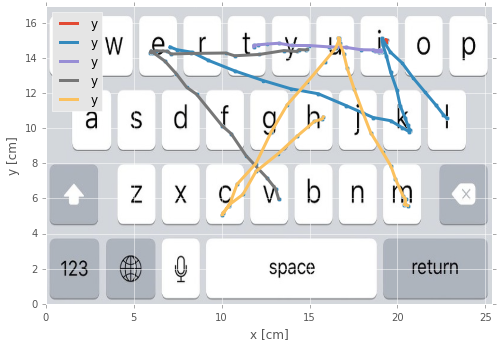

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

source = 'inferred'  # or 'ground'
sentence = 'i like it very much'

## chose 1 trial only:
session = msentences[msentences['name'] == sentence].bound.iloc[0][0]
data = touch_t[touch_t['session'] == session]

## filter the data and get the touch array
touch = touchfilter(data, source=source)

## split the sentences by selecting consecutive runs of 1s in touch array
for word_slice in ones_runs(touch):        
    word_data = data[slice(*word_slice)]

    txyt = datafilter(word_data, source=source)

    txyt.plot(x='x', y='y', ax=ax, linewidth=3)
    txyt.plot(x='x', y='y', kind='scatter', ax=ax)

sugar_plot(ax)

# Decode all the word trials

In [9]:
def decode(X, y):
    return int(y == y)

condition_cnt = 0
condition_ok = 0

## words
for i, words in mwords.iterrows():
    name = words['name']
    for session in words['bound']:
        condition_cnt += 1
        data = touch_t[touch_t['session'] == session]
        condition_ok += decode(data, name)

        
print condition_ok, '-', condition_cnt, '-', condition_ok/condition_cnt * 100, '%'

96 - 96 - 100 %


# Note on the Keyboard

The keyboard seems to be an iphone keyboard, downloaded online. During the experiment, the image was stretched over the full screen of the MS Surface, which explains the dimension **tablet_size = (25.4, 16.93)**.

In [ ]:
img_size = np.array([766, 417])
y = np.array([153, 257, 360])

top_row = np.array([40, 117, 194, 269, 344, 422, 498, 573, 650, 727])
mid_row = np.array([80, 156, 234, 310, 384, 462, 538, 614, 690])
bot_row = mid_row[1:-1]

keyboard_pos = dict()

for i, letter in enumerate('qwertyuiop'):
    keyboard_pos[letter] = np.array([top_row[i], y[2]], dtype=float) / img_size
for i, letter in enumerate('asdfghjkl'):
    keyboard_pos[letter] = np.array([mid_row[i], y[1]], dtype=float) / img_size
for i, letter in enumerate('zxcvbnm'):
    keyboard_pos[letter] = np.array([bot_row[i], y[0]], dtype=float) / img_size

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim([0,25.4])
ax.set_ylim([0,16.93])

for k, (x,y) in keyboard_pos.items():
    (x,y) = np.array((x,y)) * tablet_size
    ax.annotate(k, xy=(x,y), xytext=(x-1,y+1))
    ax.plot(x, y, 'r+', markersize=30)

ax.imshow(keyboard, zorder=0, extent=[0.0, 25.4, 0.0, 16.93])    

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')